In [92]:
from h3 import h3
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import os
import pandas as pd
from osgeo import gdal
from osgeo import osr
import geopandas as gpd
# plot one location one plot
import matplotlib.pyplot as plt
import seaborn as sns
graphicfolder = "../_graphics/viz"
from shapely.geometry import Point, Polygon, LineString
import matplotlib.ticker as mtick
plt.rcParams["figure.figsize"] = [3, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['svg.fonttype'] = 'none'
def imshow(image, show_axes = False, quiet = False):
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion since 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    plt.imshow(image)
    if not show_axes:
        # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
        plt.axis('off')
    if not quiet:
        # Make sure it outputs
        plt.show()
        

In [455]:
import matplotlib.pyplot as plt
import seaborn as sns
graphicfolder = "../_graphics/viz"
cleanfolder1 = '../_data/10_clean/00_overallsummary'
outputfolder = '../_data/10_clean/05_for_viz'
alldf = pd.read_csv(os.path.join(outputfolder, 'pedestrian_frame.csv'))

KeyboardInterrupt: 

# 1. Timeseries

In [3]:
# alldf['minute_from_start'] = alldf['second_from_start'] // 60

In [183]:
color_dict = {
    'Bryant Park': '#f77189',
 'Chestnut Street': '#97a431',
 'Downtown Crossing': '#36ada4',
 'MET': '#a48cf4'
 }

In [184]:
# Frame level aggregation
window = 60
timedf = alldf.groupby(['decades','video_location',
                              'video_id',
                              'second_from_start',
                              'frame_id',
                              'minute_from_start']).agg({
                                  'track_id': 'nunique'}).reset_index().rename(columns = {
                                      'track_id':'pedestrian_count'}).sort_values(
                                      ['video_id','second_from_start','frame_id']
                                  )
pedes_temp_min = timedf\
    .groupby(['decades','video_location','minute_from_start'])['pedestrian_count']\
        .mean().reset_index()
pedes_temp_min['pedestrian_count_rolling_10m'] = pedes_temp_min.groupby(['video_location'])\
    [f'pedestrian_count'].transform(lambda x: x.rolling(10, 1).mean())
pedes_temp_min['minute_from_start'] = pedes_temp_min['minute_from_start'].astype(int)

/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_39638/446038806.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, "timeporal_pedestrian_count.png"),


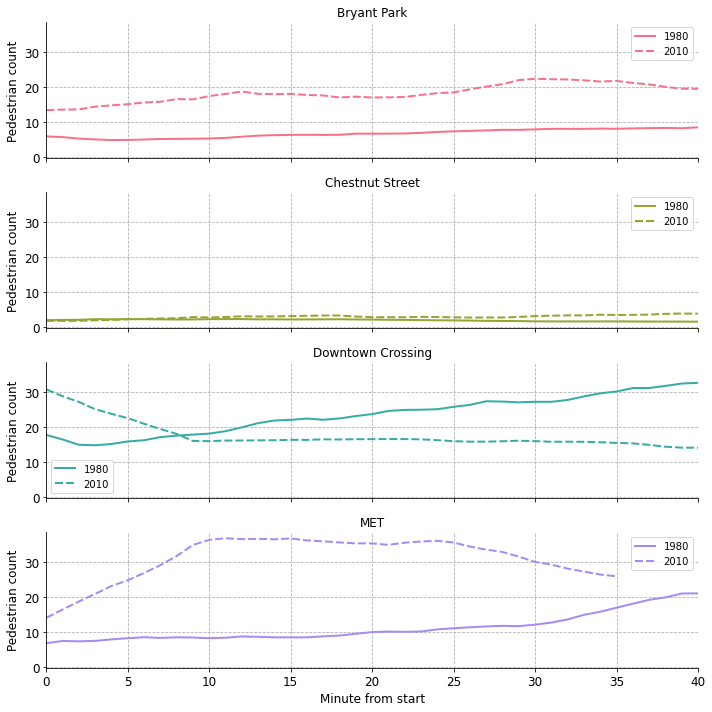

In [186]:

fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True, sharey=True)
for i, loc in enumerate(pedes_temp_min['video_location'].unique()):
    temp = pedes_temp_min[pedes_temp_min['video_location'] == loc]
    sns.lineplot(data = temp,
                 x="minute_from_start", 
             y=f"pedestrian_count_rolling_10m", 
             color = color_dict[loc],
             style = 'decades',
             ci = None,
             linewidth=2, 
             ax = axes[i])
    axes[i].set_title(loc)
    axes[i].set_xlabel('Minute from start', fontsize = 12)
    axes[i].set_ylabel('Pedestrian count', fontsize = 12)
    # set up tick size
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].legend(['1980', '2010'])
    # set x limit
    axes[i].set_xlim([0, 40])
    sns.despine()
    # show major grids
    axes[i].grid(which='major', axis='both', linestyle='--')
plt.tight_layout()
fig.savefig(os.path.join(graphicfolder, "timeporal_pedestrian_count.png"), 
            index = False, dpi = 200)

# 1. People in group overtime
## 1.1 Dyads

In [191]:
alldf['group_size_combined'] = alldf['group_size_combined'].astype(str)

In [192]:
# frame level average first
grouptimedf = alldf.groupby(['decades',
                             'video_location',
                              'video_id',
                              'second_from_start',
                              'minute_from_start',
                              'frame_id',
                              'group_size_combined']).agg({
                                  'track_id': 'nunique',
                                  }).reset_index().rename(columns = {
                                      'track_id':'pedestrian_count'})
# Pivot the table to fill the nan values
grouptimedf_loc = grouptimedf.pivot(
    columns = ['group_size_combined'], index = ['decades',
                             'video_location',
                              'video_id',
                              'second_from_start',
                              'minute_from_start',
                              'frame_id',], values = ['pedestrian_count']).fillna(0).reset_index()
grouptimedf_loc.columns = [''.join(col) for col in grouptimedf_loc.columns]
newcols = [f'pedestrian_count{i}' for i in ['1', '2', '3', '>=4']]
# total pedestrian count per frame
grouptimedf_loc['pedestrian_count_total'] = grouptimedf_loc[newcols].sum(axis = 1)
for i in ['1', '2', '3', '>=4']:
    grouptimedf_loc[f'{i}_per'] = grouptimedf_loc[f'pedestrian_count{i}'] / grouptimedf_loc['pedestrian_count_total']
grouptimedf_loc_summary = grouptimedf_loc.groupby([
                                                   'video_location',
                                                   'decades']).agg({
                                                       '1_per':'mean',
                                                       '2_per':'mean',
                                                       '3_per':'mean',
                                                       '>=4_per':'mean'
                                                   }).reset_index()
grouptimedf_loc_summary.head()


,video_location,decades,1_per,2_per,3_per,>=4_per
0,Bryant Park,1980s,0.719459,0.195652,0.054782,0.030107
1,Bryant Park,2010s,0.541532,0.303866,0.069298,0.085305
2,Chestnut Street,1980s,0.825744,0.141197,0.026876,0.006183
3,Chestnut Street,2010s,0.771875,0.202919,0.021854,0.003353
4,Downtown Crossing,1980s,0.549301,0.328038,0.079558,0.043103


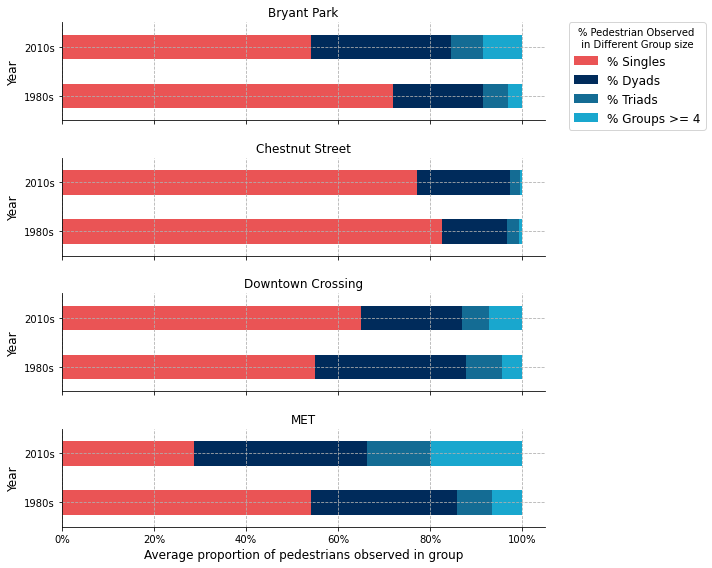

In [193]:

newcolsper = [f'{i}_per' for i in ['1', '2', '3', '>=4']]

import matplotlib.pyplot as plt
import seaborn as sns
graphicfolder = "../_graphics/viz"
fig, axes = plt.subplots(4,1, figsize=(10, 8), sharex=True, sharey=True)
for i, loc in enumerate(grouptimedf_loc_summary['video_location'].unique()):
    temp = grouptimedf_loc_summary[grouptimedf_loc_summary['video_location'] == loc].reset_index(drop = True)\
        .set_index('decades')
    temp[newcolsper].plot.barh(
        stacked = True,
        ax = axes[i],
        color = ['#EA5455', '#002B5B','#146C94', '#19A7CE'],
    )
    axes[i].set_title(loc)
    axes[i].set_xlabel('Average proportion of pedestrians observed in group', fontsize = 12)
    axes[i].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[i].grid(which='major', axis='both', linestyle='--')
    axes[i].set_ylabel("Year", fontsize = 12)
    sns.despine()
    if i ==0:
        axes[i].legend(['% Singles', '% Dyads', '% Triads', '% Groups >= 4'],
                title="% Pedestrian Observed \n in Different Group size",
                    bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    borderaxespad=0, fontsize = 'large', title_fontsize = 10)
    else:
        # remove legend
        axes[i].get_legend().remove()
plt.tight_layout()
# fig.savefig(os.path.join(graphicfolder, "Fig1-GroupPercentageOvertime.svg"), index = False, dpi = 200)


In [269]:
# unified
grouptimedf_loc_summary = grouptimedf_loc.groupby([
                                                #    'video_location',
                                                   'decades']).agg({
                                                       '1_per':'mean',
                                                       '2_per':'mean',
                                                       '3_per':'mean',
                                                       '>=4_per':'mean'
                                                   })
grouptimedf_loc_summary.head()


,1_per,2_per,3_per,>=4_per
decades,,,,
1980s,0.647454,0.249587,0.062077,0.040882
2010s,0.657817,0.242652,0.049125,0.050406


/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_39638/494166236.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, "Fig1c-GroupPercentageOvertime-combined.svg"), index = False, dpi = 200)


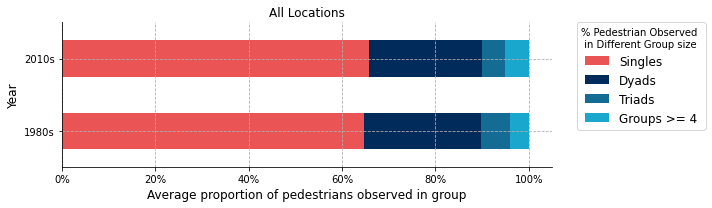

In [277]:
fig, ax = plt.subplots(figsize=(10,3))
grouptimedf_loc_summary[newcolsper].plot.barh(
        stacked = True,
        ax = ax,
        color = ['#EA5455', '#002B5B','#146C94', '#19A7CE'],
    )
ax.set_title("All Locations")
ax.set_xlabel('Average proportion of pedestrians observed in group', fontsize = 12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='both', linestyle='--')
ax.set_ylabel("Year", fontsize = 12)
ax.legend(['Singles', 'Dyads', 'Triads', 'Groups >= 4'],
                title="% Pedestrian Observed \n in Different Group size",
                    bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    borderaxespad=0, fontsize = 'large', title_fontsize = 10)
sns.despine()
fig.savefig(os.path.join(graphicfolder, "Fig1c-GroupPercentageOvertime-combined.svg"), index = False, dpi = 200)

In [194]:
grouptimedf_min_wide = grouptimedf_loc.groupby(
    ['decades',  'video_location','minute_from_start']).agg({
                                                       'pedestrian_count1':'mean',
                                                       'pedestrian_count2':'mean',
                                                       'pedestrian_count3':'mean',
                                                       'pedestrian_count>=4':'mean'
                                                   }).reset_index()
grouptimedf_min_wide.head()

,decades,video_location,minute_from_start,pedestrian_count1,pedestrian_count2,pedestrian_count3,pedestrian_count>=4
0,1980s,Bryant Park,0.0,5.152574,0.614706,0.051838,0.189338
1,1980s,Bryant Park,1.0,4.383304,0.482416,0.289520,0.450799
2,1980s,Bryant Park,2.0,3.818606,0.549928,0.114224,0.003951
3,1980s,Bryant Park,3.0,3.742585,0.547785,0.123032,0.036617
4,1980s,Bryant Park,4.0,3.611397,0.491912,0.148529,0.033088


In [195]:
# plot stacked area plot
def get_plot(grouptimedf_min_wide):
    fig, axes = plt.subplots(4,1, figsize=(6, 10), sharex=True, sharey=True)
    decade = grouptimedf_min_wide['decades'].unique()[0]
    for i, loc in enumerate(grouptimedf_min_wide['video_location'].unique()):
        temp = grouptimedf_min_wide[grouptimedf_min_wide['video_location'] == loc].reset_index(drop = True)
        axes[i].stackplot(temp['minute_from_start'],
                    temp['pedestrian_count1'],
                        temp['pedestrian_count2'],
                        temp['pedestrian_count3'],
                        temp['pedestrian_count>=4'],
                        labels = ['singles', 'dyads', 'triads', '>=4'],
                        colors = ['#EA5455', '#002B5B','#146C94', '#19A7CE'],
                        )
        axes[i].set_title(loc+" "+f"({decade})")
        if i ==3:
            axes[i].set_xlabel('Minute from start', fontsize = 12)
        else:
            axes[i].set_xlabel('')
        axes[i].set_ylabel('Pedestrian count', fontsize = 12)
        # set up tick size
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        # axes[i].legend(['1980', '2010'])
        # set x limit
        axes[i].set_xlim([0, 35])
        axes[i].set_ylim([0, 45])
        sns.despine()
        # show major grids
        axes[i].grid(which='major', axis='both', linestyle='--')
    plt.tight_layout()
    fig.savefig(os.path.join(graphicfolder, f"Fig1-dyadstemporal{decade}.svg"), index = False, dpi = 200)
                 
                 

/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_39638/3062634946.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"Fig1-dyadstemporal{decade}.svg"), index = False, dpi = 200)


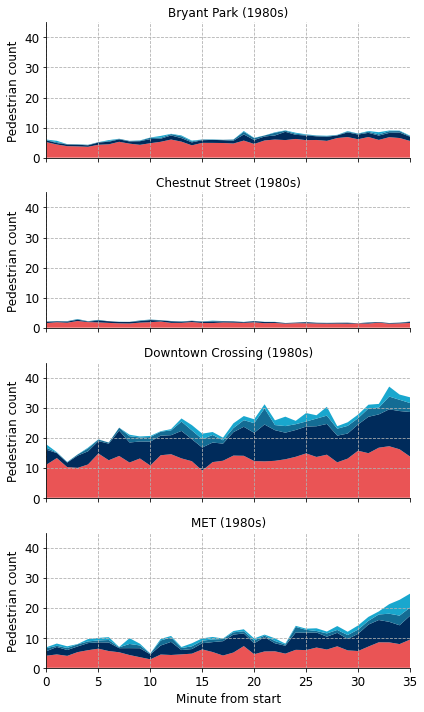

In [196]:
get_plot(grouptimedf_min_wide[grouptimedf_min_wide['decades'] == '1980s'])

/var/folders/hw/_9ws64g138s7p677clyddq480000gn/T/ipykernel_39638/3062634946.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "index" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(os.path.join(graphicfolder, f"Fig1-dyadstemporal{decade}.svg"), index = False, dpi = 200)


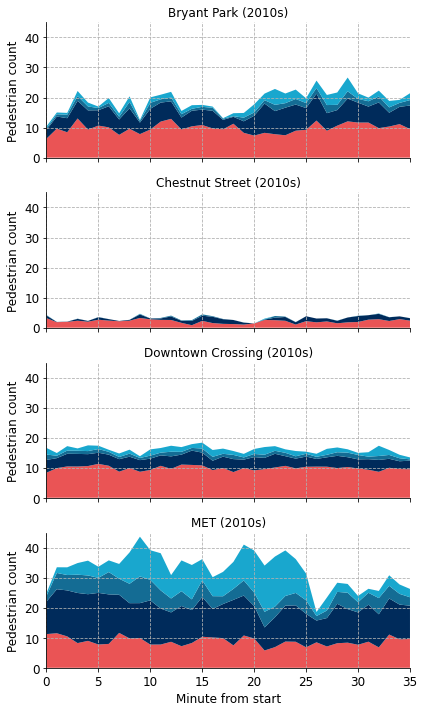

In [197]:
get_plot(grouptimedf_min_wide[grouptimedf_min_wide['decades'] == '2010s'])

# Fig-2. Lingering by groups overtime
## 2.1 % pedestrian groups stays / pedestrian in groups

In [375]:
# total number of frame per video
framecount = alldf.groupby(['decades',
                            'video_location',
                            'video_id']).agg({
                                'frame_id':'nunique',
                                'second_from_start':'max',
                                'minute_from_start':'max'
                            }).reset_index().rename(columns = {
                                'frame_id':'frame_count',
                            })
framecount_loc = framecount.groupby([
    'decades','video_location']).agg({
        'frame_count':'sum',
        'second_from_start':'max',
    }).reset_index()


framecount_min = alldf.groupby(['decades',
                            'video_location',
                            'video_id',
                            'minute_from_start']).agg({
                                'frame_id':'nunique',
                     
                            }).reset_index().rename(columns = {
                                'frame_id':'frame_count',
                            })
framecount_min.head()

,decades,video_location,video_id,minute_from_start,frame_count
0,1980s,Bryant Park,B16_G8_Env4_0001,0.0,2720
1,1980s,Bryant Park,B16_G8_Env4_0001,1.0,2815
2,1980s,Bryant Park,B16_G8_Env4_0001,2.0,2784
3,1980s,Bryant Park,B16_G8_Env4_0001,3.0,2731
4,1980s,Bryant Park,B16_G8_Env4_0001,4.0,2720


In [473]:
alldf.columns

Index(['video_location', 'track_id', 'video_id', 'lat', 'lon',
       'track_id_backup', 'moving_speed', 'hex_id', 'frame_id',
       'second_from_start', 'individual_frame_total', 'Social',
       'frame_social_track', 'group_id_social', 'group_size', 'is_group',
       'group_first_frame', 'track_first_frame', 'group_track_delta',
       'emerging_group', 'cross_frame_group_id', 'decades', 'video_group',
       'stay', 'is_group_loose', 'group_size_combined', 'minute_from_start'],
      dtype='object')

In [474]:
# person per frame per hex
def get_time_agg(df):
    """df is defnied by people's stages, in group, stay, move, etc
    Here we need to maintain the video_id given that some times a minute can cross two videos, then they may share frame ids."""
    person_frame = df.groupby(['decades',
                                'video_location',
                                'video_id',
                                'frame_id',
                                'minute_from_start'
                                ]).agg(
                                    {'track_id':'nunique'}).reset_index().rename(columns = {
                                    'track_id':'pedestrian_count',})
    person_time = person_frame.groupby(['decades',
                                        'video_location',
                                        'video_id',
                                'minute_from_start']).agg({
                                    'pedestrian_count':'sum',
                                }).reset_index()
    return person_time


# 1. All individual
person_time = get_time_agg(alldf)

# 2. All group
person_group_time = get_time_agg(alldf[alldf['group_size_combined'] != '1'])

# 3. All stays
person_stay_time = get_time_agg(alldf[alldf['stay']==True])

# 4. All crowd
person_crowd_time = get_time_agg(alldf[alldf['is_group_loose']==True])

# 5. all staying groups

person_stay_group_time = get_time_agg(alldf[(alldf['stay']==True) & (alldf['group_size_combined'] != '1')])

# 6. all singled
person_single_time = get_time_agg(alldf[alldf['group_size_combined'] == '1'])

# 7. all staying singles
person_single_stay = get_time_agg(alldf[(alldf['stay']==True) & (alldf['group_size_combined'] == '1')])

# 8. all move singles
person_single_move = get_time_agg(alldf[(alldf['stay']==False) & (alldf['group_size_combined'] == '1')])
# 9. all move groups
person_group_move = get_time_agg(alldf[(alldf['stay']==False) & (alldf['group_size_combined'] != '1')])

person_emerging = get_time_agg(alldf[alldf['emerging_group']==True])

# merge all, get the mean value directly

timedf = framecount_min.merge(person_time, on = ['decades','minute_from_start','video_location','video_id'], how = 'left')\
    .merge(person_group_time, on = ['decades','minute_from_start','video_location','video_id'], how = 'left', suffixes=('_all', '_group'))\
        .merge(person_stay_time, on = ['decades','minute_from_start','video_location','video_id'], how = 'left').rename(columns = {"pedestrian_count":"pedestrian_count_stay"})\
            .merge(person_crowd_time, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left').rename(columns = {"pedestrian_count":"pedestrian_count_crowd"})\
                .merge(person_stay_group_time, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left').rename(columns = {"pedestrian_count":"pedestrian_count_group_stay"})\
                    .merge(person_single_time, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left').rename(columns = {"pedestrian_count":"pedestrian_count_single"})\
                        .merge(person_single_stay, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left')\
                            .rename(columns = {"pedestrian_count":"pedestrian_count_single_stay"})\
                                .merge(person_single_move, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left')\
                                    .rename(columns = {'pedestrian_count':'pedestrian_count_single_move'})\
                                    .merge(person_group_move, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left')\
                                        .rename(columns = {"pedestrian_count":'pedestrian_count_group_move'}).fillna(0)\
                                            .merge(person_emerging, on = ['decades', 'minute_from_start','video_location','video_id'], how = 'left').fillna(0)\
                                                .rename(columns = {'pedestrian_count':'pedestrian_count_emerging'})
timedf.shape

(707, 15)

In [496]:
# get columns per frame value
cols = ['pedestrian_count_all', 'pedestrian_count_group',
       'pedestrian_count_stay', 'pedestrian_count_crowd',
       'pedestrian_count_group_stay', 'pedestrian_count_single',
       'pedestrian_count_single_stay', 'pedestrian_count_single_move',
       'pedestrian_count_group_move','pedestrian_count_emerging']
for c in cols:
    timedf[f"{c}_frame"] = timedf[c] / timedf['frame_count']
# redo the mean per mintue, disregarding video_id
timedf_min = timedf.groupby(['decades','video_location','minute_from_start']).max().reset_index()

In [392]:
# stack plot single stay and move, group stay and move
# plot stacked area plot
def get_plot(timedf):
    fig, axes = plt.subplots(4,1, figsize=(6, 10), sharex=True, sharey=True)
    decade = timedf['decades'].unique()[0]
    for i, loc in enumerate(timedf['video_location'].unique()):
        temp = timedf[timedf['video_location'] == loc].reset_index(drop = True)
        axes[i].stackplot(
            temp['minute_from_start'],
            temp['pedestrian_count_single_stay_frame'],
                    temp['pedestrian_count_single_move_frame'],
                        temp['pedestrian_count_group_stay_frame'],
                        temp['pedestrian_count_group_move_frame'],
                        labels = ['singles stay', 'singles move', 'group stay', 'group move'],
                        colors = ['#EA5455', '#ffbeb5','#002B5B','#b2d6ef'],
                        )
        axes[i].set_title(loc+" "+f"({decade})")
        if i ==3:
            axes[i].set_xlabel('Minute from start', fontsize = 12)
        else:
            axes[i].set_xlabel('')
        axes[i].set_ylabel('Pedestrian count', fontsize = 12)
        # set up tick size
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        # axes[i].legend(['1980', '2010'])
        # set x limit
        axes[i].set_xlim([0, 35])
        # axes[i].set_ylim([0, 45])
        sns.despine()
        # show major grids
        axes[i].grid(which='major', axis='both', linestyle='--')
        
    plt.tight_layout()
    # fig.savefig(os.path.join(graphicfolder, f"Fig1-dyadstemporal{decade}.svg"), index = False, dpi = 200)

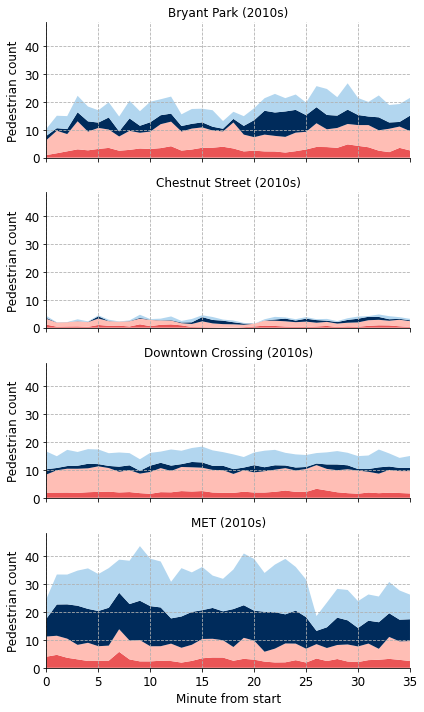

In [476]:
get_plot(timedf_min[timedf_min['decades'] == '2010s'])

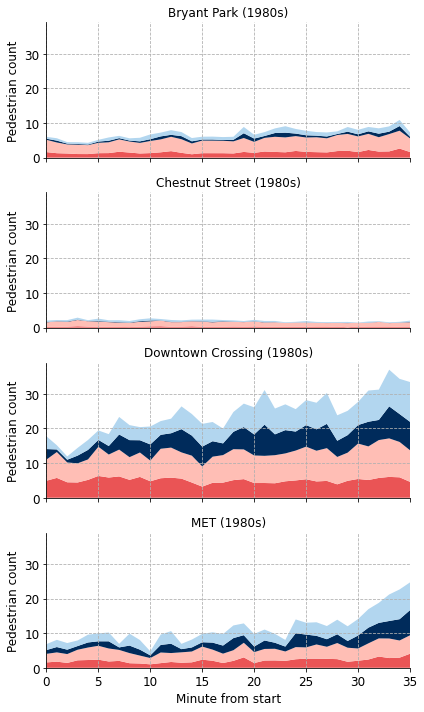

In [394]:
get_plot(timedf_min[timedf_min['decades'] == '1980s'])

In [502]:
# plot percentage of single people stay vs group people stay
timedf_min['single_stay_per'] = timedf_min['pedestrian_count_single_stay_frame'] / timedf_min['pedestrian_count_single_frame']
timedf_min['group_stay_per'] = timedf_min['pedestrian_count_group_stay_frame'] / timedf_min['pedestrian_count_group_frame']
timedf_min['emerging_per_all'] = timedf_min['pedestrian_count_emerging_frame'] / timedf_min['pedestrian_count_all_frame']
timedf_min['group_per_all'] = timedf_min['pedestrian_count_group_frame'] / timedf_min['pedestrian_count_all_frame']

In [503]:
timedf_min.to_csv(os.path.join(outputfolder, "staging_pedestrian_min_aggregated.csv"), index = False)

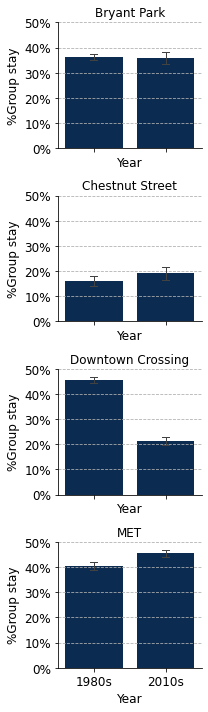

In [429]:
fig, axes = plt.subplots(4,1, figsize=(3,10), sharex=True, sharey=True)
for i, loc in enumerate(timedf_min['video_location'].unique()):
    sns.barplot(data = timedf_min[timedf_min['video_location']==loc],
                x = 'decades',
                    y = 'group_stay_per',
                    ax = axes[i],
                    errwidth=1,
                    capsize=0.1,
                    palette=['#002B5B','#002B5B']
    )
    sns.despine()
    axes[i].set_ylim([0, 0.5])
    axes[i].set_title(loc)
    axes[i].set_xlabel('Year', fontsize = 12)
    axes[i].set_ylabel('%Group stay', fontsize = 12)
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[i].grid(which='major', axis='y', linestyle='--')
    axes[i].tick_params(axis='both', which='major', labelsize=12)


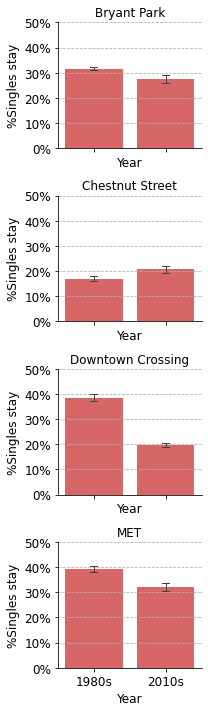

In [430]:
fig, axes = plt.subplots(4,1, figsize=(3,10), sharex=True, sharey=True)
for i, loc in enumerate(timedf_min['video_location'].unique()):
    sns.barplot(data = timedf_min[timedf_min['video_location']==loc],
                x = 'decades',
                    y = 'single_stay_per',
                    ax = axes[i],
                    errwidth=1,
                    capsize=0.1,
                    palette=['#EA5455', '#EA5455']
    )
    sns.despine()
    axes[i].set_title(loc)
    axes[i].set_ylim([0, 0.5])
    axes[i].set_xlabel('Year', fontsize = 12)
    axes[i].set_ylabel('%Singles stay', fontsize = 12)
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[i].grid(which='major', axis='y', linestyle='--')
    axes[i].tick_params(axis='both', which='major', labelsize=12)

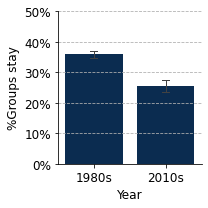

In [442]:
fig, ax = plt.subplots(figsize=(3,3))

sns.barplot(data = timedf_min,
            x = 'decades',
                y = 'group_stay_per',
                    ax = ax,
                    errwidth=1,
                    capsize=0.1,
                    palette=['#002B5B','#002B5B']
)
sns.despine()

ax.set_ylim([0, 0.5])
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('%Groups stay', fontsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=12)

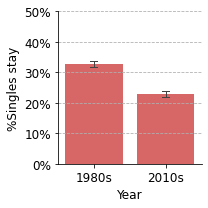

In [443]:
fig, ax = plt.subplots(figsize=(3,3))

sns.barplot(data = timedf_min,
            x = 'decades',
                y = 'single_stay_per',
ax = ax,
                errwidth=1,
                capsize=0.1,
                palette=['#EA5455', '#EA5455']
)
sns.despine()

ax.set_ylim([0, 0.5])
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('%Singles stay', fontsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=12)

In [481]:
timedf_min = timedf_min[~timedf_min['group_stay_per'].isna()]
timedf_min = timedf_min[~timedf_min['single_stay_per'].isna()].reset_index(drop = True)

In [493]:
# t-test between group_stay_per and single_stay_per
from scipy import stats
# resultdf = pd.DataFrame()
decades = '1980s'
mean_group_1980 = timedf_min[timedf_min['decades'] == decades]['group_stay_per'].mean()
mean_single_1980 = timedf_min[timedf_min['decades'] == decades]['single_stay_per'].mean()
tt = stats.ttest_ind(timedf_min[timedf_min['decades'] == decades]['group_stay_per'],
                timedf_min[timedf_min['decades'] == decades]['single_stay_per'])
diff = mean_group_1980 - mean_single_1980
print("Mean group: ",  mean_group_1980)
print("Mean single: ",  mean_single_1980)
print("Mean differences: ", diff)
print("ttest:",  tt)


Mean group:  0.35900417012084135
Mean single:  0.3276543743726635
Mean differences:  0.03134979574817787
ttest: Ttest_indResult(statistic=3.721962025454939, pvalue=0.00021787109618090776)


In [492]:
decades = '2010s'
mean_group_1980 = timedf_min[timedf_min['decades'] == decades]['group_stay_per'].mean()
mean_single_1980 = timedf_min[timedf_min['decades'] == decades]['single_stay_per'].mean()
tt = stats.ttest_ind(timedf_min[timedf_min['decades'] == decades]['group_stay_per'],
                timedf_min[timedf_min['decades'] == decades]['single_stay_per'])
diff = mean_group_1980 - mean_single_1980
print("Mean group: ",  mean_group_1980)
print("Mean single: ",  mean_single_1980)
print("Mean differences: ", diff)
print("ttest:",  tt)

Mean group:  0.25454148644766045
Mean single:  0.229548839461315
Mean differences:  0.024992646986345457
ttest: Ttest_indResult(statistic=2.402279152127273, pvalue=0.01653801882982147)


# 3. Spontaneous Collision
## 3.1 all location: people in sponteous, people in group, people always alone

In [507]:
timedf_min.groupby(['video_location','decades']).agg({
    'emerging_per_all':'mean',
    'group_per_all':"mean"
}).to_csv(os.path.join(outputfolder, 'spontanouscollision.csv'))

# 4. Spatiall Agg
1. Percentage of time occupied by a person staying per hexagon.
2. Percentage of time occupied by a group
3. Average number of person shown in each frame in a hexagon (spatial usage similarity)
4. Occurance of emerging group (spontenous collision)
4. Total frames for each hexes should be consistent across video_id

In [244]:
# load all shapes, only keep the ones that are inside the videos
foldershp = '/Users/yuan/Dropbox (MIT)/whyte_CV/_data/02_siteplan/site_plan_geometry'

shpdf = gpd.read_file(os.path.join(foldershp, "final_h3_15_four_city.geojson")).drop('video_location', axis = 1)\
    .rename(columns = {'location_name':'video_location'})
shpdf.head()

,hex_id,index_right,video_location,geometry
0,8f2a134d4559053,0,Chestnut Street,"POLYGON ((-75.15793 39.95020, -75.15793 39.950..."
1,8f2a134d4559ae1,0,Chestnut Street,"POLYGON ((-75.15773 39.95016, -75.15773 39.950..."
2,8f2a134d4559046,0,Chestnut Street,"POLYGON ((-75.15790 39.95021, -75.15790 39.950..."
3,8f2a134d4559a69,0,Chestnut Street,"POLYGON ((-75.15763 39.95014, -75.15764 39.950..."
4,8f2a134d4559052,0,Chestnut Street,"POLYGON ((-75.15793 39.95021, -75.15794 39.950..."


In [260]:
# person per frame per hex
def get_hex_agg(df):
    """df is defnied by people's stages, in group, stay, move, etc"""
    person_frame = df.groupby(['decades',
                                'video_location',
                                'video_id',
                                'frame_id',
                                'hex_id']).agg(
                                    {'track_id':'nunique'}).reset_index().rename(columns = {
                                    'track_id':'pedestrian_count',})
    person_loc = person_frame.groupby(['decades',
                                # 'video_location',
                                'hex_id']).agg({
                                    'pedestrian_count':'sum',
                                }).reset_index()
    return person_loc
# 1. All people
person_loc = get_hex_agg(alldf)
# 2. People in group
person_group_loc = get_hex_agg(alldf[alldf['group_size_combined'] != '1'])

# 3. People stay
person_stay_loc = get_hex_agg(alldf[alldf['stay'] == True])

# 4. People in emerging group
person_emerging_loc = get_hex_agg(alldf[alldf['emerging_group']==True])

# 5. People in a crowd, (not necessarily always in group, but tend to cluster)
person_crowd_loc = get_hex_agg(alldf[alldf['is_group_loose']==True])

# 6. People in group and stay
person_group_stay_loc = get_hex_agg(alldf[(alldf['group_size_combined'] != '1') & (alldf['stay'] == True)])

In [245]:
shpdf = shpdf[['hex_id', 'geometry','video_location']].copy()
shpdf2y = shpdf[['hex_id', 'geometry','video_location']].copy()
shpdf2y['decades'] = '2010s'
shpdf['decades'] = '1980s'
shpdf2y = pd.concat([shpdf2y, shpdf], axis = 0)
shpdf2y.shape

(2722, 4)

In [445]:
import gc
gc.collect()

0

In [261]:
# merge all together
h3df = shpdf2y.merge(person_loc, on = ['hex_id', 'decades'], 
                   how = 'left')\
    .merge(person_group_loc, on = ['hex_id', 'decades'],
           how = 'left', suffixes=("_all", "_group"))\
    .merge(person_stay_loc, on = ['hex_id', 'decades'],
           how = 'left').rename(columns = {'pedestrian_count':
                  'pedestrian_count_stay'})\
    .merge(person_emerging_loc, on = ['hex_id', 'decades'],
           how = 'left').rename(columns = {'pedestrian_count':
                  'pedestrian_count_emerging_group'})\
    .merge(person_crowd_loc, on = ['hex_id', 'decades'],
           how = 'left').rename(columns = {'pedestrian_count':
                  'pedestrian_count_crowd'}).fillna(0)\
       .merge(person_group_stay_loc, on = ['hex_id', 'decades'],
           how = 'left').rename(columns = {'pedestrian_count':
                  'pedestrian_count_stay_group'}).fillna(0)\
       .merge(framecount_loc, on = ['decades', 'video_location'],
              how = 'left')
h3df.shape

(2722, 13)

In [461]:
h3df.to_file(os.path.join(outputfolder, "h3_geo.geojson"), driver='GeoJSON')
# h3df.to_file(os.path.join(outputfolder, "h3_geo.shp"))

/Users/yuan/opt/anaconda3/envs/geo38/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [470]:
metadata = {
    'pedestrian_count_all':'total pedestrian count (all frames)', 
    'pedestrian_count_group':'total pedestrian ever participate in a group',
       'pedestrian_count_stay':'total pedestrian every stay (speed<0.5 m/s)', 
       'pedestrian_count_emerging_group':'total pedestrian ever in an spontanous group',
       'pedestrian_count_crowd':'total pedestrian ever within a spatial cluster', 
       'pedestrian_count_stay_group':'total pedestrian ever in a group and stay', 
       'frame_count':'total frame count per video location',
       'second_from_start':'approximate second from video start',
       'minute_frome_start':'approximate minute from video start', 
       'pedestrian_count_all_frame':'total pedestrian count per frame',
       'pedestrian_count_group_frame': 'total pedestrian count in a group per frame',
       'pedestrian_count_stay_frame':'total pedestrian ever stay per frame',
       'pedestrian_count_emerging_group_frame':'pedestrian in an spontanous group per frame',
       'pedestrian_count_crowd_frame':'pedestrian count ever in a spatial cluster per frame',
       'pedestrian_count_stay_group_frame':'pedestrian ever stay per frame'
}
import json
with open(os.path.join(outputfolder, "h3_geo_meta.json"), "w") as the_file:
  json.dump(metadata, the_file, indent=4)

In [457]:
# get everything per frame
colssave = []
for x in ['pedestrian_count_all', 'pedestrian_count_group',
       'pedestrian_count_stay', 'pedestrian_count_emerging_group',
       'pedestrian_count_crowd','pedestrian_count_stay_group']:
    h3df[f'{x}_frame'] = h3df[x] / h3df['frame_count']
    colssave.append(f'{x}_frame')
    

In [459]:
#wide table
h3_wide = h3df.pivot(
    index = ['video_location', 'hex_id'],
    columns = ['decades'],
    values = colssave,
           ).reset_index()
h3_wide.columns = [''.join(col) for col in h3_wide.columns]
h3_wide

,video_location,hex_id,pedestrian_count_all_frame1980s,pedestrian_count_all_frame2010s,pedestrian_count_group_frame1980s,pedestrian_count_group_frame2010s,pedestrian_count_stay_frame1980s,pedestrian_count_stay_frame2010s,pedestrian_count_emerging_group_frame1980s,pedestrian_count_emerging_group_frame2010s,pedestrian_count_crowd_frame1980s,pedestrian_count_crowd_frame2010s,pedestrian_count_stay_group_frame1980s,pedestrian_count_stay_group_frame2010s
0,Bryant Park,8f2a100d66a9806,0.002325,0.007673,0.000605,0.002820,0.000379,0.004676,0.000046,0.002290,0.000850,0.003049,0.000131,0.001289
1,Bryant Park,8f2a100d66a9810,0.003012,0.008793,0.000455,0.002791,0.000628,0.004256,0.000101,0.000309,0.000536,0.002563,0.000177,0.001230
2,Bryant Park,8f2a100d66a9812,0.001553,0.006053,0.000213,0.001267,0.000160,0.001937,0.000118,0.000074,0.000334,0.001576,0.000007,0.000221
3,Bryant Park,8f2a100d66a9814,0.019889,0.061350,0.004915,0.029287,0.006730,0.023403,0.000356,0.006701,0.006298,0.030576,0.001831,0.008830
4,Bryant Park,8f2a100d66a9815,0.010625,0.058743,0.000909,0.015155,0.005043,0.052101,0.000069,0.007710,0.001194,0.017924,0.000311,0.013277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1356,MET,8f2a100890aabb0,0.004545,0.010272,0.000864,0.002443,0.001431,0.000776,0.000000,0.000162,0.001563,0.005177,0.000300,0.000000
1357,MET,8f2a100890aabb1,0.000995,0.005403,0.000321,0.001003,0.000407,0.000226,0.000000,0.000032,0.000502,0.003154,0.000074,0.000000
1358,MET,8f2a100890aabb2,0.002998,0.005516,0.000543,0.001553,0.000893,0.000372,0.000058,0.000032,0.000716,0.002054,0.000321,0.000113
1359,MET,8f2a100890aabb3,0.005725,0.005840,0.001090,0.001957,0.001530,0.000146,0.000070,0.000162,0.002381,0.003365,0.000090,0.000000


In [460]:
h3_wide.to_csv(os.path.join(outputfolder, 'h3_wide.csv'), index = False)

In [466]:
# calculate correlation and pvalue by location
from scipy.stats import pearsonr
col = 'pedestrian_count_all_frame'
result = []
for loc in h3_wide['video_location'].unique():
    temp = h3_wide[h3_wide['video_location'] == loc]
    print(loc, pearsonr(temp[col+'1980s'], temp[col+'2010s']))
    corr_result = pearsonr(temp[col+'1980s'], temp[col+'2010s'])
    result.append([loc, corr_result[0], corr_result[1]])
resultdf = pd.DataFrame({
    'video location':[x[0] for x in result],
    'correlation':[x[1] for x in result],
    "p-value":[x[2] for x in result]
})
resultdf.to_csv(os.path.join(outputfolder, "spatial_correlation.csv"), index = False)

Bryant Park (0.4802122653348217, 4.260907784463159e-17)
Chestnut Street (0.16806772339894818, 0.03783574980700293)
Downtown Crossing (0.03375830063091949, 0.4815066992842298)
MET (-0.006842021908677604, 0.8788259738561908)


<AxesSubplot:xlabel='1980s', ylabel='2010s'>

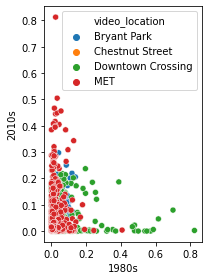

In [450]:
sns.scatterplot(
    data = h3_wide,
    x = '1980s',
   y = '2010s',
   hue = 'video_location' 
)

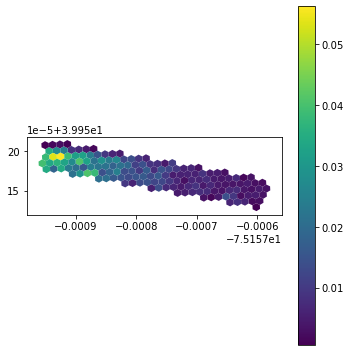

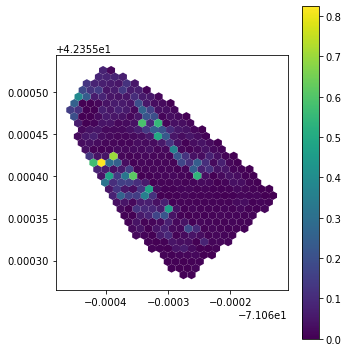

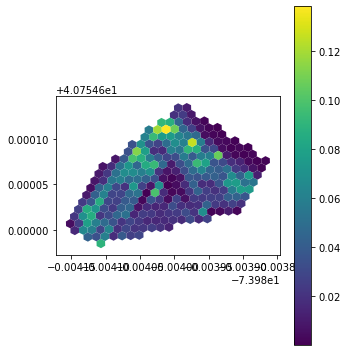

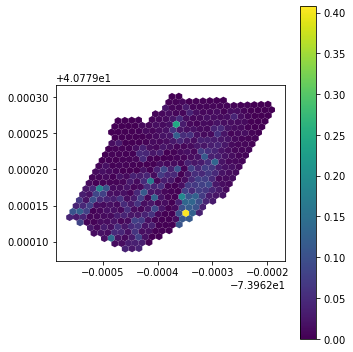

In [452]:
for loc in h3df['video_location'].unique():
    temp = h3df[(h3df['decades']=='1980s')&(h3df['video_location']==loc)]
    temp.plot(figsize = (5,5),
        column = 'pedestrian_count_all_frame',
        legend = True
    )

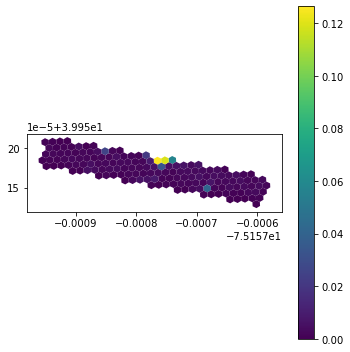

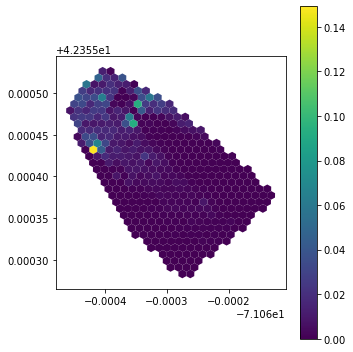

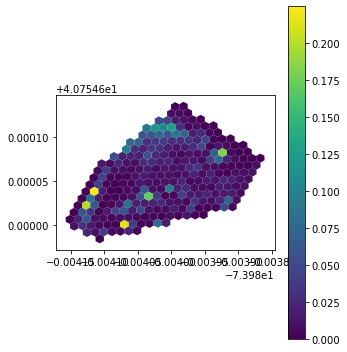

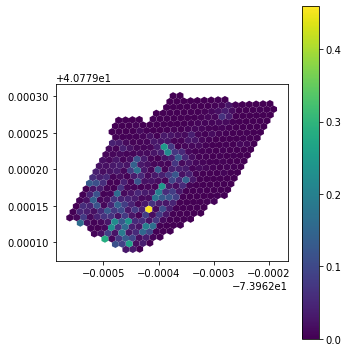

In [453]:
for loc in h3df['video_location'].unique():
    temp = h3df[(h3df['decades']=='2010s')&(h3df['video_location']==loc)]
    temp.plot(figsize = (5,5),
        column = 'pedestrian_count_stay_frame',
        legend = True
    )

In [ ]:
# construct a wide view
